# Redes Neuronales Artificiales - Trabajo Práctico 2

### Guillermina Cabrol, Magalí Giansiracusa, Sofía Goldberg

In [1]:
%matplotlib widget

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## Introducción

En este trabajo buscamos obtener modelos de redes neuronales artificiales, basados en aprendizaje no supervisado, que logren aprender de un conjunto de documentos con descripciones de texto de compañías brasileñas. La idea es que lo modelos no solo logren aprender estos datos, sino también generalizar sobre nuevas instancias. 

In [2]:
import requests

r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp2_training_dataset.csv')
data = np.loadtxt(r.iter_lines(), delimiter=',')

Para que todos los resultados sean reproducible utilizaremos una seed.

In [3]:
random_seeded = np.random.RandomState(seed=42)

A continuación separamos las categoría de los atributos de cada documento. Además, vamos a normalizamos dichos atributos.

In [4]:
categories = data[:,0]

X = data[:,1:]

X = (X - X.mean(axis=0)) / X.std()

## Reducción de dimensión

Nuestro primer objetivo será obtener dos modelos de redes neuronales artificiales que logren reducir la dimensión de los documentos en el conjunto de datos. Éstos van a diferir en la regla utilizada para actualizar los pesos: uno utilizará la **Regla de Oja** y otro la **Regla de Sanger**.

En particular, dada una instancia de dimensión $N$, queremos encontrar una representación de dimensión $M = 9$. Esto se logra llevando las instancias al subespacio generado por sus $9$ primeras componentes principales.

In [19]:
P = X.shape[0]  # Cantidad de instancias
N = X.shape[1]  # Dimensión de entrada
M = 9           # Dimensión de salida

Como criterio de corte para los algoritmos utilizaremos la ortogonalidad, y variaremos el valor óptimo que debe llegar a tomar ésta para encontrar el mejor modelo.

In [20]:
def orthogonality(W: np.ndarray):
    M = W.shape[1]
    return np.sum(np.abs(np.dot(W.T, W) - np.identity(M))) / 2


Inicializamos los pesos con valores al azar, con una distribución normal:

In [21]:
def initialize_weights(N: int, M: int):
    return random_seeded.normal(0, 0.1, (N, M))

Definimos los algoritmos a utilizar para calcular la corrección de los pesos:

In [22]:
def oja_correction(W: np.ndarray, X: np.ndarray, Y: np.ndarray):
    Z = np.dot(Y, W.T)
    return np.outer(X - Z, Y)


def sanger_correction(W, X, Y):
    M = W.shape[1]
    D = np.triu(np.ones((M, M)))
    Z = np.dot(W, Y.T * D)
    return (X.T - Z) * Y

Por último, definimos la función que utilizaremos para entrenar la red, en la cual se puede variar el método de cálculo de corrección de los pesos. 

Aclaración: usamos la librería `typing` para que queden más claros los tipos que toma la función.

In [24]:
from typing import Callable

CorrectionFunc = Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray]

def PCA_train(
    X: np.ndarray,
    M: int,
    corr: CorrectionFunc,
    *,
    epochs: int = 1000,
    ort_threshold: float = 0.01,
    lr: float = 0.001,
) -> np.ndarray:
    
    fig = plt.figure()

    W = initialize_weights(X.shape[1], M)
    current_lr = lr
    orthogonalities = []

    for t in range(1, epochs + 1):
        for i in range(X.shape[0]):
            x = X[i].reshape(1, -1)
            Y = np.dot(x, W)
            W += current_lr * corr(W, x, Y)

        o = orthogonality(W)
        orthogonalities.append(o)

        if o < ort_threshold:
            break

        if t % 100 == 0:
            print(f"Época: {t:03}, ortogonalidad: {o}")

        current_lr = lr / t
        
    plt.plot(orthogonalities)
    plt.show()

    return W

Además, definimos una función para poder graficar los resultados.

In [25]:
def graphic_representation(Y):
    AX_LIM = 20

    fig = plt.figure(figsize=(10, 10))

    for i in range(3):
        compA, compB, compC = 3 * i, 3 * i + 1, 3 * i + 2

        xyz = fig.add_subplot(1, 3, i + 1, projection="3d")
        xyz.set_xlim(-AX_LIM, AX_LIM)
        xyz.set_ylim(-AX_LIM, AX_LIM)
        xyz.set_zlim(-AX_LIM, AX_LIM)
        xyz.scatter3D(Y[:, compA], Y[:, compB], Y[:, compC], c=categories, cmap='Set1')

        # Labeling
        xyz.set_xlabel(f"PC{compA}")
        xyz.set_ylabel(f"PC{compB}")
        xyz.set_zlabel(f"PC{compC}")

        xyz.set_title(f"PCA Oja - PC{compA} vs PC{compB} vs PC{compC}")

    fig.tight_layout(pad=5.0)

    plt.show()

### Regla de Oja

Época: 100, ortogonalidad: 0.022479321988923627
Época: 200, ortogonalidad: 0.011194674258882768


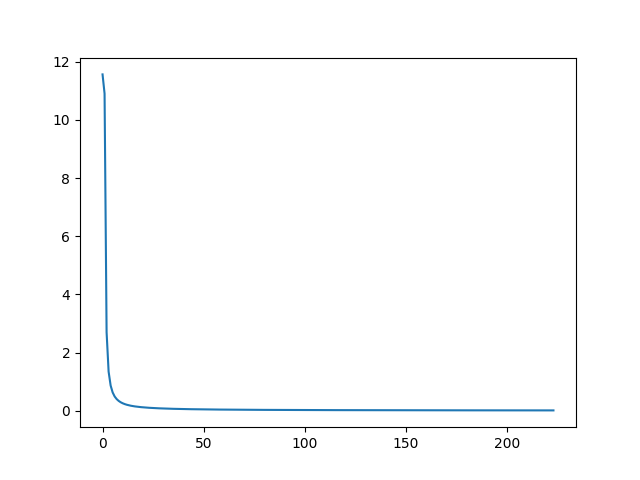

In [26]:
W_oja = PCA_train(X, M, oja_correction)

In [27]:
Y_oja = np.dot(X, W_oja)

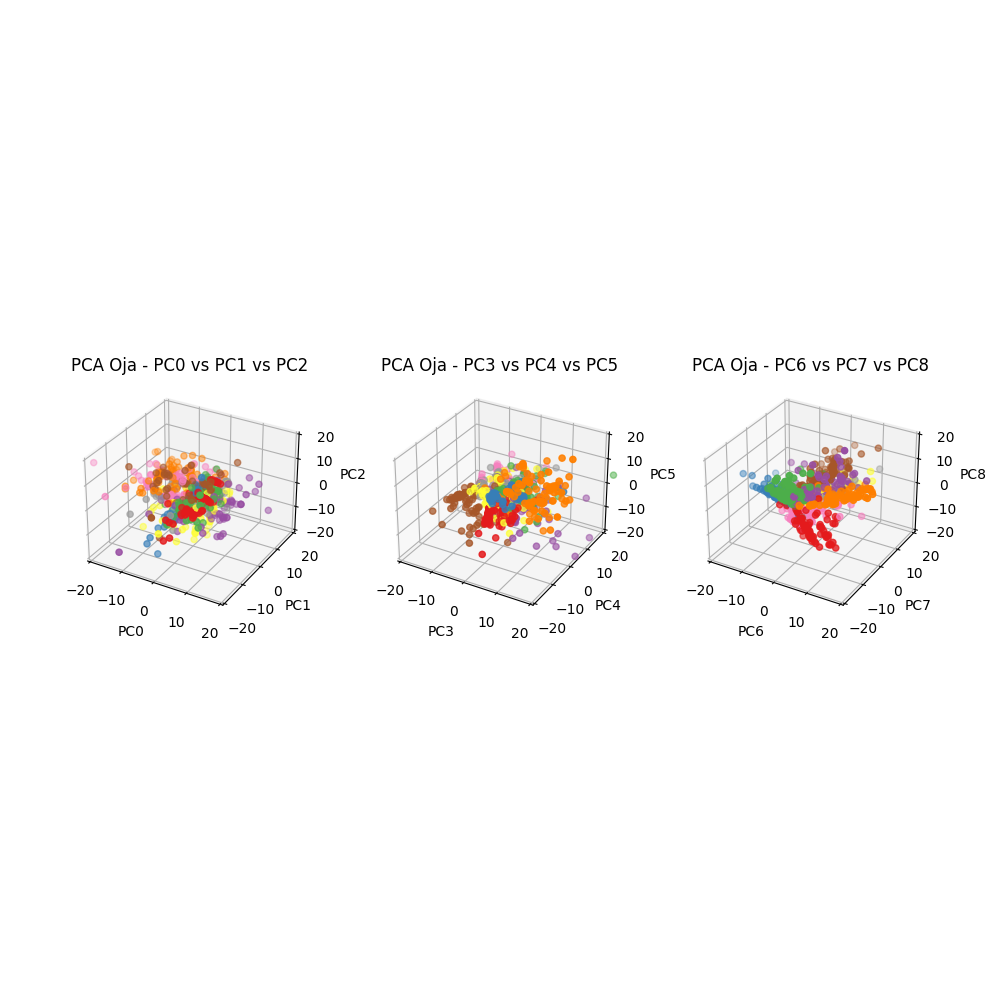

In [28]:
graphic_representation(Y_oja)

### Regla de Sanger

Época: 100, ortogonalidad: 0.11672062191692753
Época: 200, ortogonalidad: 0.05893146751027719
Época: 300, ortogonalidad: 0.03941707955388322
Época: 400, ortogonalidad: 0.029613606862984712
Época: 500, ortogonalidad: 0.02371649991543735
Época: 600, ortogonalidad: 0.019778677991248966
Época: 700, ortogonalidad: 0.016962715281173574
Época: 800, ortogonalidad: 0.01484892359887018
Época: 900, ortogonalidad: 0.013203753855045715
Época: 1000, ortogonalidad: 0.01188689931759781


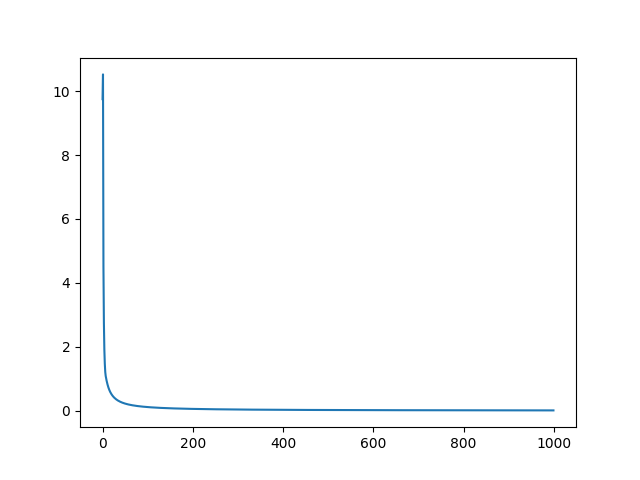

In [29]:
W_sanger = PCA_train(X, M, sanger_correction)

In [20]:
Y_sanger = np.dot(X, W_sanger)

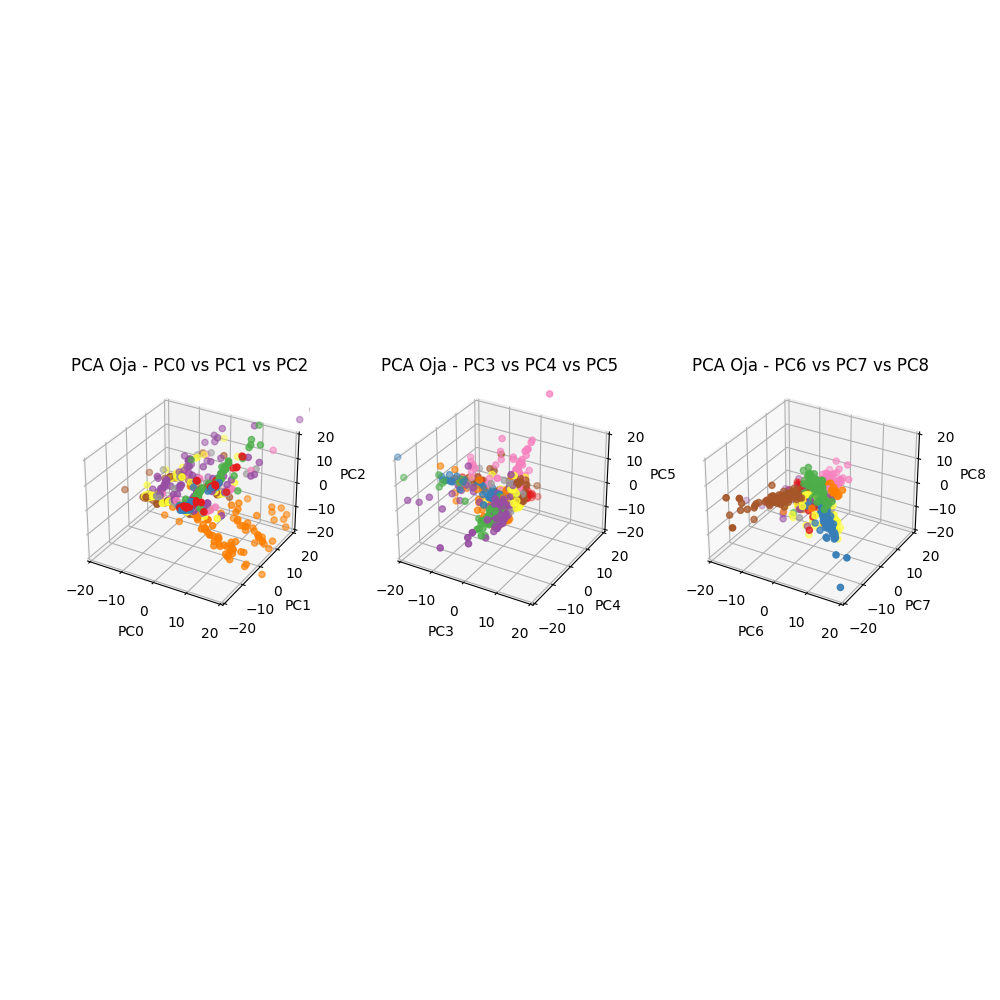

In [21]:
graphic_representation(Y_sanger)

## Mapeo de características

In [14]:
N = X.shape[1]
M = 9

In [16]:
epochs = 10
lr_st = 1.0
lr_dr = 0.1
ir_st = 3
ir_dr = 0.05

In [17]:
Y = np.zeros((M,M))
W = random_seeded.normal( 0,1, (M,M,N))

for t in range(epochs):
   for i in range(X.shape[0]):
        x = X[i]
        e = x - W
        n = np.linalg.norm(e, axis=2)

        p = np.unravel_index(np.argmin(n), n.shape)

        Y[:] = 0
        Y[p] = 1

        lr = lr_st * np.exp(-t * lr_dr)
        ir = ir_st * np.exp(-t * ir_dr)

        il = [[(x, Y) for Y in range(M)] for x in range(M)]
        im = np.array(il)

        d = np.linalg.norm(im-p, axis=2)

        pf = np.exp(-d/(2*np.square(ir))).reshape((M,M,1))

        dW = lr * pf * e
        W += dW



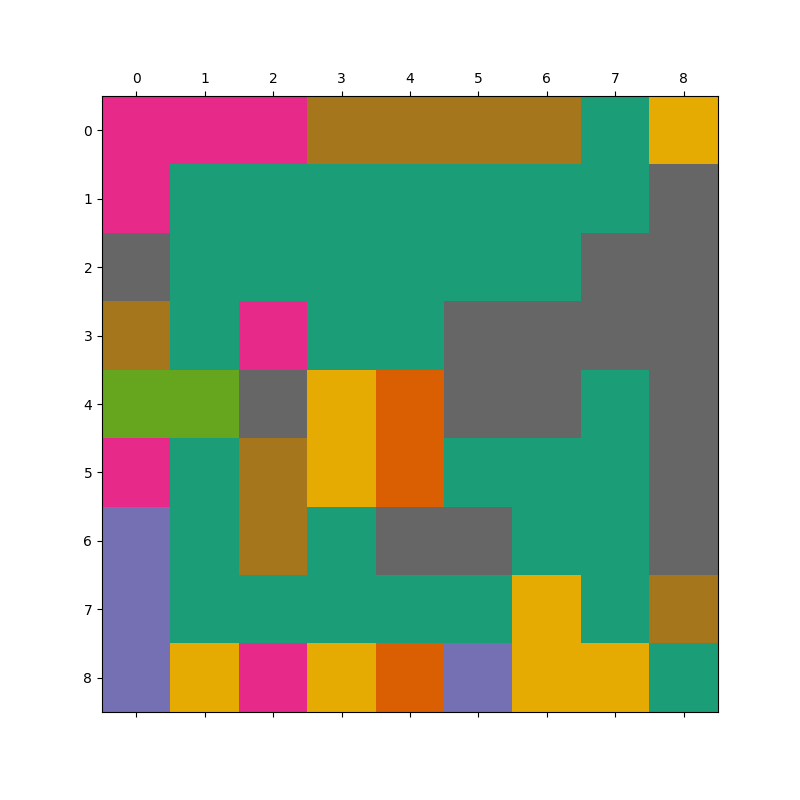

In [36]:
labels = np.arange(1, 10)

predicted_categories = np.zeros((M, M), dtype=int)

for i in range(X.shape[0]):
    x = X[i]
    e = x - W
    n = np.linalg.norm(e, axis=2)
    p = np.unravel_index(np.argmin(n), n.shape)
    predicted_categories[p] = categories[i]

fig, ax = plt.subplots(figsize=(8,8))
cax = ax.matshow(predicted_categories, cmap='Dark2')

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(M))

plt.show()

    

